# Preprocess data

# Methods

In [650]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [651]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 72

# green, red, blue, yellow, purple, blue, grey
flatui = ["#2DEC2A","#F6204F","#33CCFF","#FFCC33","#9b59b6","#25BCFE","#95a5a6"]
default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF","#F9AE23"]

def fontsize(ax, fz = 14):
    """Set all fontsizes to fz"""
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fz)

def labels(ax, title=None, subtitle=None, xlabel=None, ylabel=None, xticklabels = None, legend_title = None, legend_labels=None, legend_loc = 'upper right', fz=14, grid=True):
    """Assign titles and labels.
    xticklabels and legend_labels should be lists, all others are strings."""
    if title is not None:
        if subtitle is None:
            plt.title(title)
        else:
            plt.suptitle(title, y=1, fontsize=fz+2)
            plt.title(subtitle)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if legend_title is not None and legend_labels is not None:
        handles, ax_legend_labs = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel);
    if ylabel is not None:
        plt.ylabel(ylabel);
    if grid:
        plt.grid(linestyle='dotted')
    fontsize(ax, fz)

def annotate(ax, x, y, text, offset=5):
    """Place text in different locations of the plot.
    x and y are lists of locations on the plot. text can be a list of numbers or strings."""
    for i in range(len(x)):
        ax.text(x[i], y[i]+offset, text[i], bbox={'facecolor':'white','pad':5}, horizontalalignment='center')

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [652]:
from scipy import stats
EPS = 1e-12
def robust_transform(x, rescale=True):
    h = 1/(1 + np.exp( - (x-np.nanmedian(x)) / (1.35 * stats.iqr(x[np.isfinite(x)]) + EPS) ))
    if rescale:
        h = (h - np.nanmin(h)) / (np.nanmax(h) - np.nanmin(h) + EPS)
    return h

# Load data

In [667]:
X = np.load('/local/home/Asif/data/tmp/ards_hr.npy')
X = np.concatenate((X, np.load('/local/home/Asif/data/tmp/ards_NISysABP.npy')))
X = X[np.isnan(X).sum(1) == 0]

In [668]:
# for i in range(X.shape[0]):
#     X[i,:] = robust_transform(X[i,:])

In [669]:
# min-max normalize
EPS = 1e-9
X = (X-X.min(axis=1)[:,np.newaxis])/(X.max(axis=1)-X.min(axis=1) + EPS)[:,np.newaxis]

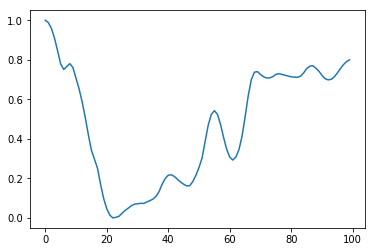

In [670]:
plt.plot(X[22,:],'-')

# Sparse coding

In [673]:
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import chain
from functools import partial
import torch.nn.functional as F

In [1028]:
from torch.optim import Optimizer
class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [1029]:
class TiedAutoEncoder(nn.Module):
    def __init__(self, timesteps, ndim):
        """
        Args:
            timesteps: number of timesteps
            ndim: number of sparse codes
        """
        super().__init__()
        self.param = nn.Parameter(torch.randn(ndim, timesteps))
        self.dropout = nn.Dropout(0.25)

    def forward(self, input, codes=False):
        """
        Args:
            input: time series of shape (batch_size, timesteps)
            Values must be scaled [0,1]
        Returns:
            encoded: sparse codes
            reconstructed: reconstructed input
        """
        encoded = torch.sigmoid(F.linear(self.dropout(input), self.param))
        if codes: # return only sparse codes
            return encoded
        reconstructed = torch.sigmoid(F.linear(encoded, self.param.t()))
        return encoded, reconstructed

class Learner:
    def __init__(self, model, optimizer, lossfun, step_size=0.01, device='cpu', cyclic=True):
        self.model = model.to(device)
        self.optimizer = optimizer(self.model.parameters())
        if cyclic:
            self.scheduler = CyclicLR(self.optimizer)
        self.lossfun = lossfun
        self.device = device
        self.cyclic = cyclic
        self.loss_history = []
        self.learn_rates = []

    def fit(self, x, epochs, batch_size, cyclic=True):
        self.cyclic = cyclic
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                if self.cyclic:
                    self.scheduler.batch_step()
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(x[idx : min(idx + batch_size, x.shape[0]), :]).float().to(self.device).requires_grad_(False)
                encoded, decoded = self.model(batch_x)
                loss = self.lossfun(encoded, decoded, batch_x, batch_size, self.model.param)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            self.learn_rates.append(self.optimizer.param_groups[0]['lr'])
            if (e+1) % 1 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))

    def predict(self, x, train=False):
        if train:
            self.model.train()
        else:
            self.model.eval()
        return [_.cpu().detach().numpy() for _ in self.model(torch.from_numpy(x).float().to(self.device).requires_grad_(False))]

In [1070]:
reg_sparsity = 0.01 # encoding sparsity
reg_weights = 0.001 # weight regularizer
reg_grp = 0.001 # weight group lasso
reg_smooth = 0.01 # smoothness regularizer

def aeloss(encoded, decoded, x, batch_size, weights):
    # mean squared error
    mse = (x - decoded) ** 2
    mse = mse.view(1, -1).sum(1) / batch_size
    loss = mse

    # sparsify encoding
    loss = loss + reg_sparsity * torch.abs(encoded.view(1, -1)).sum(1)

    # penalize large weights
    # without this regularizer the learned basis
    # can have very large values
    loss = loss + reg_weights * torch.sqrt((weights**2).view(1,-1).sum())

    # group lasso regularization with l2,1 norm
    # constrains the network to use as few filters as possible
    # sqrt of sum of squares over timesteps, them sum over filters
    loss = loss + reg_grp * torch.sqrt(torch.sum((weights**2),dim=1)).view(1,-1).sum()

    # smoothness penalty on learned basis
    d1 = weights[:,0:-1] - weights[:,1:]
    d2 = d1[:,0:-1] - d1[:,1:]
    loss = loss + reg_smooth * torch.sqrt((d2**2).view(1,-1).sum())
    return loss

ndim = 30
model = TiedAutoEncoder(X.shape[1], ndim)
learner = Learner(model, partial(torch.optim.Adam, lr=0.01), aeloss, device="cuda", cyclic=True)

In [1071]:
learner.fit(X, epochs=10, batch_size=32, cyclic=False)

Epoch 1: 10.412013053894043
Epoch 2: 6.491856575012207
Epoch 3: 5.8974995613098145
Epoch 4: 5.866942882537842
Epoch 5: 5.863319396972656
Epoch 6: 5.8578338623046875
Epoch 7: 5.858785152435303
Epoch 8: 5.8580241203308105
Epoch 9: 5.856350898742676
Epoch 10: 5.857840538024902


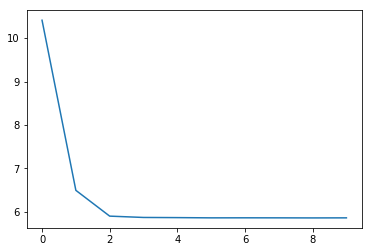

In [1080]:
plt.plot(learner.loss_history)

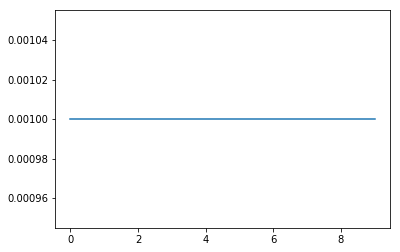

In [1081]:
plt.plot(learner.learn_rates)

In [1082]:
W = learner.model.param.cpu().detach().numpy()
W.shape

(30, 100)

In [1083]:
codes, reconstructed = learner.predict(X[0:1000, :])

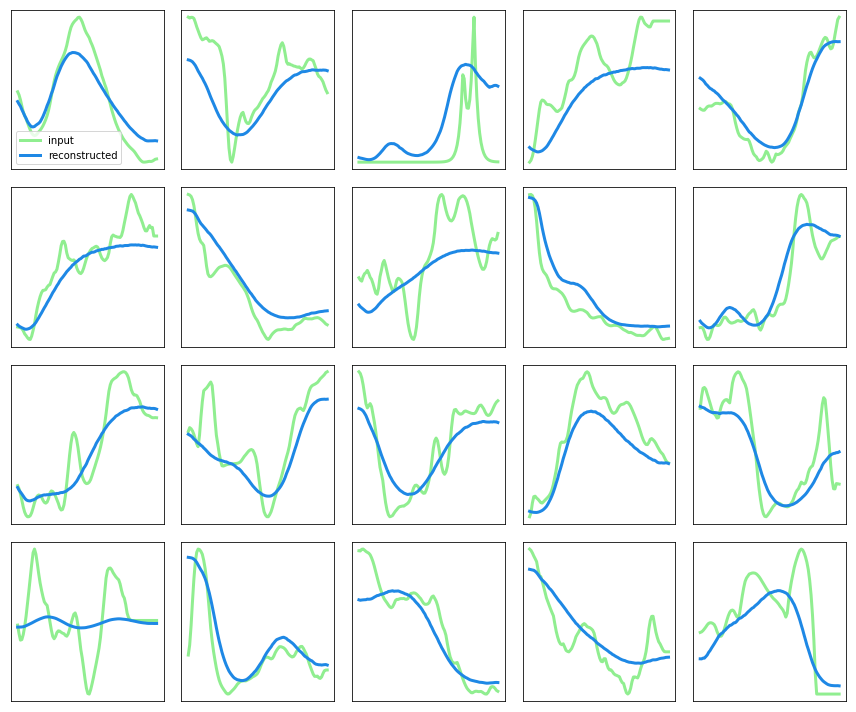

In [1084]:
offset = 10

plt.figure(figsize=(12,10))
for i in range(20):
    ax = plt.subplot(4,5,i+1)
    plt.plot(X[i+offset,:],'-',color='lightgreen',lw=3,label='input')
    plt.plot(reconstructed[i+offset,:],lw=3,label='reconstructed',color=default_colors[0])
    plt.xticks([]);plt.yticks([]);
    if i == 0:
        plt.legend()
plt.tight_layout()

[0.22 0.   0.22 0.   0.   0.22 0.22 0.22 0.99 0.99 0.22 0.13 0.22 0.22
 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.23 0.   0.22 0.22 0.22 0.9  0.19
 0.22 0.22]


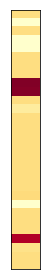

In [1085]:
i = 12
plt.figure(figsize=(0.8,4))
ax = plt.subplot(1,1,1)
print(np.round(codes[i,:],2))
plt.imshow(codes[i:i+1,:].T, interpolation='none', aspect='auto', cmap=plt.cm.YlOrRd)
plt.yticks([]);plt.xticks([]);plt.clim([0,1]);
plt.tight_layout()

In [1086]:
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram
pdist=spatial.distance.pdist(W)
D = spatial.distance.squareform(pdist)
Z = linkage(D,'ward')
dn = dendrogram(Z,no_plot=True)
# from tslearn.metrics import cdist_dtw
# D = cdist_dtw(W)

/local/home/Asif/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


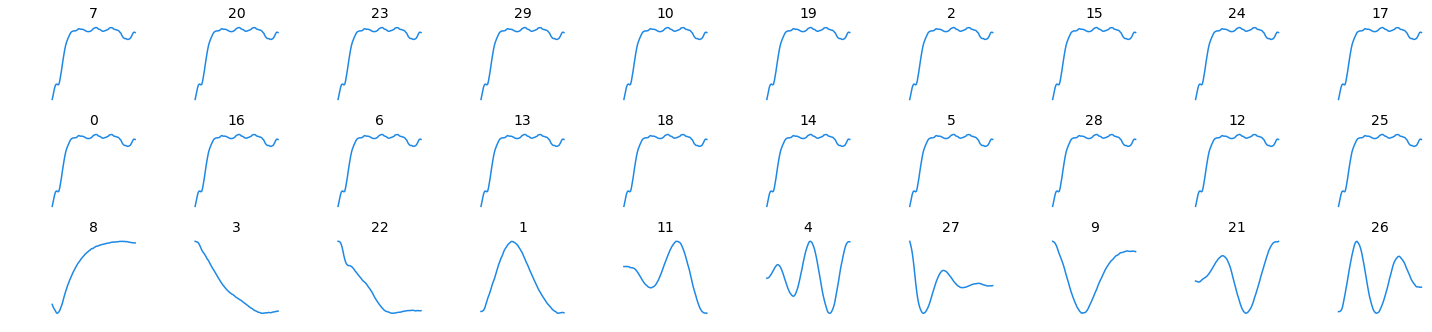

In [1087]:
idx = [int(i) for i in dn['ivl']]
# idx = np.argsort(D[16,:])
plt.figure(figsize=(20,15))
for i,k in enumerate(idx):
    ax = plt.subplot(10,10,i+1)
    plt.plot(W[k,:],color=default_colors[0]);
    plt.xticks(())
    labels(ax, title=k)
    plt.axis('off')
plt.tight_layout()

# Convolutional AE

In [927]:
xt = torch.tensor(X[0:32,np.newaxis,:]).float()
xt.shape

torch.Size([32, 1, 100])

In [980]:
l1 = nn.Linear(672,10)
l2 = nn.Linear(10,5)
l3 = nn.Linear(5,672)

c1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=9)
c2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=9)

t1 = nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=9)
t2 = nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=9)

encode = c2(c1(xt))
vec = encode.view(-1,encode.size(1)*encode.size(2))
code = l2(l1(vec))
recode = l3(code).view(-1,encode.size(1),encode.size(2))
decode = t2(t1(recode)).squeeze(1)

In [981]:
encode.shape, vec.shape, code.shape, recode.shape, decode.shape

(torch.Size([32, 8, 84]),
 torch.Size([32, 672]),
 torch.Size([32, 5]),
 torch.Size([32, 8, 84]),
 torch.Size([32, 100]))

In [1195]:
batchNorm_momentum = 0.1

conv11 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
bn11 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
conv12 = nn.Conv1d(8, 8, kernel_size=3, padding=1)
bn12 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)

conv12d = nn.Conv1d(8, 8, kernel_size=3, padding=1)
bn12d = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
conv11d = nn.Conv1d(8, 1, kernel_size=3, padding=1)

x11 = F.relu(bn11(conv11(xt)))
x12 = F.relu(bn12(conv12(x11)))
x1p, id1 = F.max_pool1d(x12, kernel_size=2, stride=2, return_indices=True)
size1 = x12.size()

x1d = F.max_unpool1d(x1p, id1, kernel_size=2, stride=2, output_size=list(size1))
x12d = F.relu(bn12d(conv12d(x1d)))
x11d = conv11d(x12d)
x11d.shape

torch.Size([32, 1, 100])

In [1235]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, ndim=10):
        """
        Args:
            timesteps: number of timesteps
            ndim: number of sparse codes
        """
        super().__init__()
        self.l1 = nn.Linear(672,50)
        self.l2 = nn.Linear(50,ndim)
        self.l3 = nn.Linear(ndim,50)
        self.l4 = nn.Linear(50,672)

        self.c1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=9)
        self.c2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=9)

        self.t1 = nn.ConvTranspose1d(in_channels=8, out_channels=4, kernel_size=9)
        self.t2 = nn.ConvTranspose1d(in_channels=4, out_channels=1, kernel_size=9)

    def forward(self, input, codes=False):
        """
        Args:
            input: time series of shape (batch_size, timesteps)
            Values must be scaled [0,1]
        Returns:
            encoded: sparse codes
            reconstructed: reconstructed input
        """
        x = torch.sigmoid(self.c1(input))
        x = torch.sigmoid(self.c2(x))
        n = x.size(1)
        m = x.size(2)
        x = x.view(-1,n*m)
        x = torch.sigmoid(self.l1(x))
        code = torch.sigmoid(self.l2(x))
        x = torch.sigmoid(self.l3(code))
        x = torch.sigmoid(self.l4(x))
        x = x.view(-1,n,m)
        x = torch.sigmoid(self.t1(x))
        decode = torch.sigmoid(self.t2(x)).squeeze(1)
        return code, decode

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        batchNorm_momentum = 0.1
#         self.conv11 = nn.Conv1d(1, 8, kernel_size=3, padding=1)
#         self.bn11 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
#         self.conv12 = nn.Conv1d(8, 8, kernel_size=3, padding=1)
#         self.bn12 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)

#         self.conv12d = nn.Conv1d(8, 8, kernel_size=3, padding=1)
#         self.bn12d = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
#         self.conv11d = nn.Conv1d(8, 1, kernel_size=3, padding=1)

        self.conv11 = nn.Conv1d(1, 8, kernel_size=9, padding=4)
        self.bn11 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
        self.conv12 = nn.Conv1d(8, 8, kernel_size=9, padding=4)
        self.bn12 = nn.BatchNorm1d(8, momentum=batchNorm_momentum)

        self.conv12d = nn.Conv1d(8, 8, kernel_size=9, padding=4)
        self.bn12d = nn.BatchNorm1d(8, momentum=batchNorm_momentum)
        self.conv11d = nn.Conv1d(8, 1, kernel_size=9, padding=4)
        
        self.linear = nn.Linear(100,100)

    def forward(self, input):
#         x11 = F.relu(self.bn11(self.conv11(input)))
#         x12 = F.relu(self.bn12(self.conv12(x11)))
#         x1p, id1 = F.max_pool1d(x12, kernel_size=2, stride=2, return_indices=True)
#         size1 = x12.size()

#         x1d = F.max_unpool1d(x1p, id1, kernel_size=2, stride=2, output_size=list(size1))
#         x12d = F.relu(self.bn12d(self.conv12d(x1d)))
#         x11d = torch.sigmoid(self.conv11d(x12d).squeeze(1))

        x11 = F.relu(self.conv11(input))
        x12 = F.relu(self.conv12(x11))
        x1p, id1 = F.max_pool1d(x12, kernel_size=2, stride=2, return_indices=True)
        size1 = x12.size()

        x1d = F.max_unpool1d(x1p, id1, kernel_size=2, stride=2, output_size=list(size1))
        x12d = F.relu(self.conv12d(x1d))
        x11d = torch.sigmoid(self.linear(self.conv11d(x12d).squeeze(1)))
        return x11d


class ConvLearner:
    def __init__(self, model, optimizer, lossfun, step_size=0.01, device='cpu', cyclic=True):
        self.model = model.to(device)
        self.optimizer = optimizer(self.model.parameters())
        if cyclic:
            self.scheduler = CyclicLR(self.optimizer)
        self.lossfun = lossfun
        self.device = device
        self.cyclic = cyclic
        self.loss_history = []
        self.learn_rates = []

    def fit(self, x, epochs, batch_size, cyclic=True):
        self.cyclic = cyclic
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                if self.cyclic:
                    self.scheduler.batch_step()
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(x[idx : min(idx + batch_size, x.shape[0]), np.newaxis, :]).float().to(self.device).requires_grad_(False)
                decoded = self.model(batch_x)
                loss = self.lossfun(decoded, batch_x, batch_size)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            self.learn_rates.append(self.optimizer.param_groups[0]['lr'])
            if (e+1) % 1 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))

    def predict(self, x, train=False):
        if train:
            self.model.train()
        else:
            self.model.eval()
        return [_.cpu().detach().numpy() for _ in self.model(torch.from_numpy(x).float().to(self.device).requires_grad_(False))]

In [1236]:
reg_sparsity = 0.1 # encoding sparsity
reg_weights = 0.001 # weight regularizer
reg_grp = 0.001 # weight group lasso
reg_smooth = 0.01 # smoothness regularizer

def convaeloss(decoded, x, batch_size):
    # mean squared error
    mse = (x - decoded) ** 2
    mse = mse.view(1, -1).sum(1) / batch_size
    loss = mse

    # sparsify encoding
#     loss = loss + reg_sparsity * torch.abs(encoded.view(1, -1)).sum(1) /batch_size

    # penalize large weights
    # without this regularizer the learned basis
    # can have very large values
#     loss = loss + reg_weights * torch.sqrt((weights**2).view(1,-1).sum())

    # group lasso regularization with l2,1 norm
    # constrains the network to use as few filters as possible
    # sqrt of sum of squares over timesteps, them sum over filters
#     loss = loss + reg_grp * torch.sqrt(torch.sum((weights**2),dim=1)).view(1,-1).sum()

    # smoothness penalty on learned basis
#     d1 = weights[:,0:-1] - weights[:,1:]
#     d2 = d1[:,0:-1] - d1[:,1:]
#     loss = loss + reg_smooth * torch.sqrt((d2**2).view(1,-1).sum())
    return loss

ndim = 10
convmodel = SegNet()
convlearner = ConvLearner(convmodel, partial(torch.optim.Adam, lr=0.01), convaeloss, device="cuda", cyclic=False)

In [1237]:
convlearner.fit(X, epochs=20, batch_size=128, cyclic=False)

Epoch 1: 1235.7957763671875
Epoch 2: 1235.8616943359375
Epoch 3: 1235.5440673828125
Epoch 4: 1235.9632568359375
Epoch 5: 1235.81005859375
Epoch 6: 1235.5908203125
Epoch 7: 1235.5399169921875
Epoch 8: 1235.891845703125
Epoch 9: 1235.6578369140625
Epoch 10: 1235.5648193359375
Epoch 11: 1235.6793212890625
Epoch 12: 1235.7835693359375
Epoch 13: 1235.5389404296875
Epoch 14: 1235.8011474609375
Epoch 15: 1235.7677001953125
Epoch 16: 1235.7506103515625
Epoch 17: 1235.5028076171875
Epoch 18: 1235.8271484375
Epoch 19: 1235.735595703125
Epoch 20: 1235.6065673828125


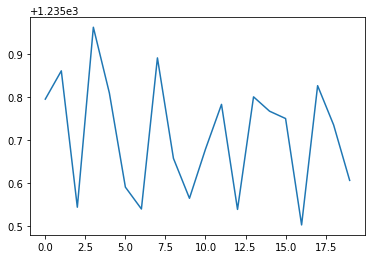

In [1238]:
plt.plot(convlearner.loss_history)

In [1239]:
reconstructed = convlearner.predict(X[0:1000, np.newaxis, :])

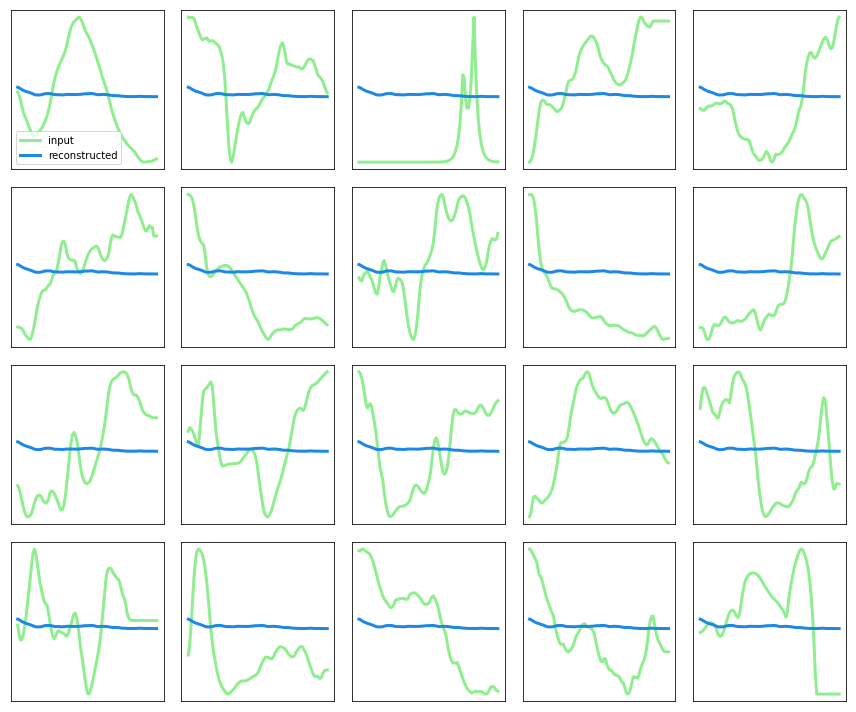

In [1240]:
offset = 10

plt.figure(figsize=(12,10))
for i in range(20):
    ax = plt.subplot(4,5,i+1)
    plt.plot(X[i+offset,:],'-',color='lightgreen',lw=3,label='input')
    plt.plot(reconstructed[i+offset],lw=3,label='reconstructed',color=default_colors[0])
    plt.xticks([]);plt.yticks([]);
    if i == 0:
        plt.legend()
plt.tight_layout()